In [15]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [16]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])
df.head()

,image,label
0,ESP_013049_0950_RED-0067.jpg,7
1,ESP_013049_0950_RED-0067-fv.jpg,7
2,ESP_013049_0950_RED-0067-brt.jpg,7
3,ESP_013049_0950_RED-0067-r90.jpg,7
4,ESP_013049_0950_RED-0067-r180.jpg,7


In [17]:
df["label"].value_counts() # need to include imbalance handling

label
0    52722
1     5024
6     1834
4     1654
3     1575
7      896
2      766
5      476
Name: count, dtype: int64

In [18]:
df.iloc[0][0], df.iloc[0][1]

('ESP_013049_0950_RED-0067.jpg', 7)

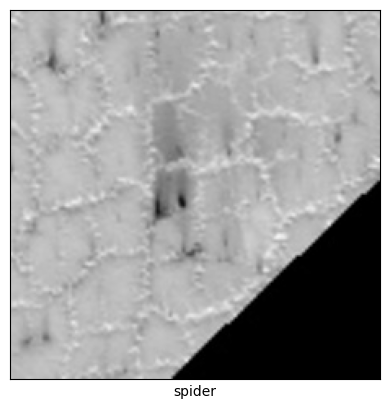

In [33]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.imshow(cv2.imread("map-proj-v3_2/" + df.iloc[0][0]))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel(class_names[df.iloc[0][1]])
plt.show()

In [34]:
def split_train_test(data, folder, test_ratio, number_of_images):
    shuffled_indices = np.random.permutation(len(data)) # indices in shuffled order
    test_set_size = int(len(data) * test_ratio) # size of test set
    
    train = data.iloc[shuffled_indices[:test_set_size]] # first x rows of data (train set)
    test = data.iloc[shuffled_indices[test_set_size:]] # last x rows of data (test set)

    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for i in range(len(train)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+train.iloc[i][0])
        if img is not None:
            train_images.append(img)
            train_labels.append(train.iloc[i][1])
    for i in range(len(test)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+test.iloc[i][0])
        if img is not None:
            test_images.append(img)
            test_labels.append(test.iloc[i][1])

    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

In [21]:
train_images, train_labels, test_images, test_labels = split_train_test(df, "map-proj-v3_2/", 0.2, 100)
print("train images:", type(train_images), "\ntest images:", type(test_images), # numpy arrays of images
      "\ntrain labels:", type(train_labels), "\ntest labels:", type(test_labels)) # lists of labels

print(train_labels[:5]) # 5 labels
print(train_images.shape) # 100 images, 256x256, 3 channels

train images: <class 'numpy.ndarray'> 
test images: <class 'numpy.ndarray'> 
train labels: <class 'numpy.ndarray'> 
test labels: <class 'numpy.ndarray'>
[1 0 4 0 0]
(100, 227, 227, 3)


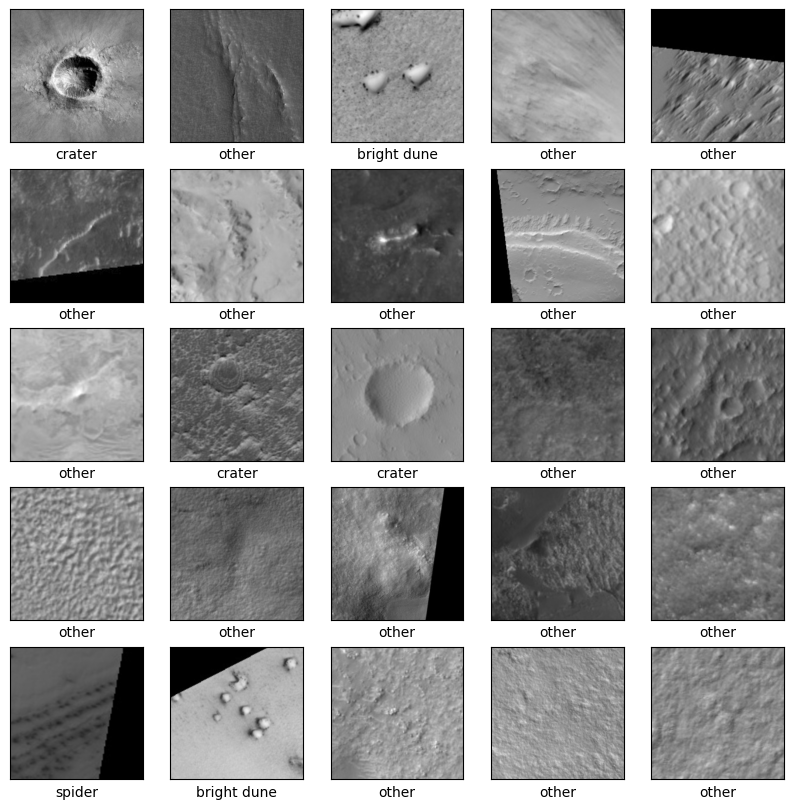

In [22]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]) # cmap=plt.cm.binary
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [23]:
model = models.Sequential()

# Convolutional Base
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense Layer ontop
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [24]:
# display the architecture of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 53, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 179776)           

In [25]:
# Compile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 797.4905 - accuracy: 0.2800 - val_loss: 146.9216 - val_accuracy: 0.8000
Epoch 2/10
4/4 [==============================] - 6s 2s/step - loss: 159.6357 - accuracy: 0.5100 - val_loss: 23.5193 - val_accuracy: 0.8000
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 26.0502 - accuracy: 0.8200 - val_loss: 16.4989 - val_accuracy: 0.0700
Epoch 4/10
4/4 [==============================] - 10s 2s/step - loss: 8.3280 - accuracy: 0.5900 - val_loss: 4.6716 - val_accuracy: 0.4000
Epoch 5/10
4/4 [==============================] - 11s 3s/step - loss: 5.5728 - accuracy: 0.7000 - val_loss: 2.8620 - val_accuracy: 0.7800
Epoch 6/10
4/4 [==============================] - 15s 3s/step - loss: 2.7525 - accuracy: 0.8600 - val_loss: 2.1521 - val_accuracy: 0.7800
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.8186 - accuracy: 0.8800 - val_loss: 2.2422 - val_accuracy: 0.6200
Epoch 8/10
4/4 [=============

4/4 - 2s - loss: 13.5017 - accuracy: 0.7600 - 2s/epoch - 378ms/step


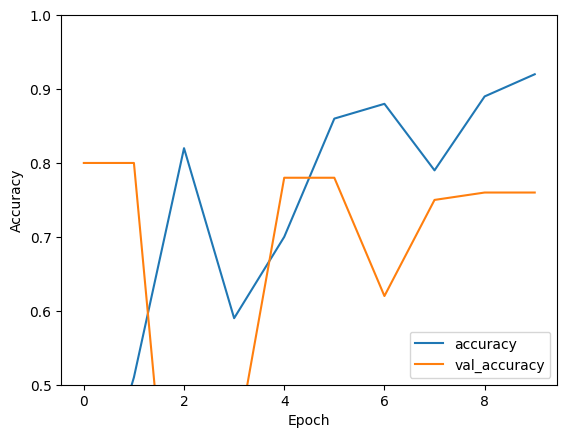

In [26]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [27]:
print(test_acc)

0.7599999904632568


# OLD CODE

------------------------------------------------------------------------------------------------

In [28]:
def load_images_from_folder_excel(folder, mapping, number_of_images):
    images = []
    labels = []
    for i in range(len(mapping)):
        if i == number_of_images:
            break
        img = cv2.imread(folder+"/"+mapping.iloc[i][0])
        if img is not None:
            images.append(img)
            labels.append(mapping.iloc[i][1])
    return images, labels

In [29]:
train_images, train_labels = load_images_from_folder_excel("map-proj-v3_2", mapping, 100)
print(len(train_images))
print(train_labels[:5])
print(train_images[:5])

NameError: name 'mapping' is not defined